# Тестирование гипотезы по увеличению выручки интернет-магазина

<div style="border: solid seagreen 1px; padding: 10px">

Отдел маркетинга интернет-магазина подготовил список гипотез для увеличения выручки.
    
**Наша задача** — приоритизировать гипотезы, выбрать наиболее перспективную, оценить успешность А/В теста, запущенного по выбранной гипотезе и принять решение об остановке или продолжении тестирования. 

**Источники информации**: список гипотез с оценками по методу RICE (reach, impact, confidence, effort), данные по выручке в разрезе транзакций (с указанием id пользователя и группы теста) и ежедневные данные по числу новых уникальных пользователей в разрезе групп теста.
    
В рамках поставленных задач будут выполнены следующие шаги:
- [приоритизация гипотез](#hypothesis_ranking),
- [обзор данных по тесту](#overview),
- [предобработка данных](#data_processing),
- [исследовательский анализ данных](#EDA),
- [оценка результатов A/B тестирования](#AB_test),
- [выводы](#summary).

In [1]:
# импортируем библиотеки
import pandas as pd
import scipy.stats as st
import numpy as np
import datetime as dt

# импортируем библиотеки для построения графиков
import matplotlib.pyplot as plt

# настраиваем отображение колонок датафрейма при выводе данных
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 100

<a id='hypothesis_ranking'></a>
## Приоритизация гипотез

### Обзор данных

In [2]:
# загружаем данные

try:
    data = pd.read_csv('/datasets/hypothesis.csv')
except:
    data = pd.read_csv(
    '/Users/mrmrzpn/Desktop/Yandex Praktikum/2. Проекты/6. Принятие решений в бизнесе/hypothesis.csv')

In [3]:
# смотрим информацию о датафрейме

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В файле представлено 9 гипотез по увеличению выручки интернет-магазина в следующей детализации:
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

### Предобработка данных

Тип данных во всех столбцах корректный, однако для удобства работы с датафреймом исправим названия колонок - все буквы переведем в нижний регистр.

In [4]:
data.columns = data.columns.str.lower()

### Приоритизация гипотез

#### Фреймворк ICE

In [5]:
# считаем показатель ICE для гипотез
data['ice'] = (data['impact'] * data['confidence']) / data['efforts']

# приоритизируем гипотезы по ICE
display(data[['hypothesis','ice']].sort_values(by='ice', ascending=False))

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


**Наблюдения:** По фреймворку ICE наиболее перспективные гипотезы:  
- 8 - предоставление скидки в день рождения,
- 0 - запуск двух новых каналов привлечения трафика,
- 7 - добавление формы подписки на email-рассылки на все основные страницы сайта,
- 6 - добавление на главной странице баннеров с актуальными акциями и распродажами,
- 2 - добавление блоков рекомендаций товаров.

#### Фреймворк RICE

In [6]:
# считаем показатель RICE для гипотез
data['rice'] = (data['reach'] * data['impact'] * data['confidence']) / data['efforts']

# приоритизируем гипотезы по RICE
display(data[['hypothesis','rice']].sort_values(by='rice', ascending=False))

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Наблюдения:** Порядок наиболее перспективных гипотез по фреймворку RICE выглядит иначе, потому что здесь учтен параметр Reach — охват пользователей.  
На первом месте с большим отрывом теперь гипотеза 7 *(добавление формы подписки на email-рассылки на все основные страницы сайта)*, параметр Reach которой максимален (равен 10), а лидер по фреймворку ICE - гипотеза о скидке в день рождения - ближе к аутсайдерам, чем к лидерам.  

Считаем, что добавление формы подписки на новостную рассылку на все страницы сайта позволит увеличить выручку интернет-магазина эффективнее, чем другие рассматриваемые методы. Далее оценим результаты тестирования этой гипотезы.

<a id='overview'></a>
## Обзор данных по тесту

По выбранной гипотезе был проведен A/B тест. Оценим полученные результаты, которые представлены в файлах /datasets/orders.csv и /datasets/visitors.csv.

In [7]:
# загружаем данные

try:
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    orders = pd.read_csv(
    '/Users/mrmrzpn/Desktop/Yandex Praktikum/2. Проекты/6. Принятие решений в бизнесе/orders.csv')
    visitors = pd.read_csv(
    '/Users/mrmrzpn/Desktop/Yandex Praktikum/2. Проекты/6. Принятие решений в бизнесе/visitors.csv')

In [8]:
# смотрим информацию о датафреймах

for i in [orders, visitors]:
    name = [key for key in globals() if globals()[key] is i]
    print('Датасет', name[0], '\n')
    i.info()
    display(i.head())
    print('--'*50)

Датасет orders 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


----------------------------------------------------------------------------------------------------
Датасет visitors 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


----------------------------------------------------------------------------------------------------


**Наблюдения:** Пропусков в данных нет, однако требуется предобработка: надо исправить названия столбцов в датафрейме orders (привести к нижнему регистру), изменить тип данных в столбцах с датами, проверить данные на наличие дубликатов.

<a id='data_processing'></a>
## Предобработка данных

### Исправление названий столбцов

In [9]:
# приводим названия столбцов к нижнему регистру

orders.columns = [column.replace('Id', '_id') for column in orders.columns]

### Изменение типа данных

In [10]:
# в столбцах с датами делаем тип данных - "дата"

orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])

### Проверка на наличие дубликатов

In [11]:
orders.duplicated().sum()

0

In [12]:
visitors.duplicated().sum()

0

Полных дубликатов нет. Проверим датафрейм orders на дублирование visitor_id: наличие одного клиента в обеих группах А и В:

In [13]:
# посчитаем число задублированных клиентов, если таковые есть

duplicated_visitors = orders.groupby('visitor_id').agg({'group':'nunique'}).query('group > 1')
len(duplicated_visitors)

58

Мы нашли 58 клиентов, которые в исследовании попали и в группу А, и в группу В. Посмотрим, какую долю от групп они составляют:

In [14]:
# численность покупателей группы А
print('Численность покупателей группы А -', orders.query('group == "A"')['visitor_id'].nunique())

# доля задублированных покупателей
print('Доля покупателей группы А, которые также попали в группу В, - {:.2%}'
      .format(len(duplicated_visitors)/orders.query('group == "A"')['visitor_id'].nunique())
     )

# численность посетителей группы А
print('Численность посетителей группы А -', visitors.query('group == "A"')['visitors'].sum())

# конверсия посетителей группы А
print('Конверсия посетителей группы А, включая тех, которые также попали в группу В, - {:.2%}'
      .format(orders.query('group == "A"')['visitor_id'].nunique()
              /visitors.query('group == "A"')['visitors'].sum())
     )

Численность покупателей группы А - 503
Доля покупателей группы А, которые также попали в группу В, - 11.53%
Численность посетителей группы А - 18736
Конверсия посетителей группы А, включая тех, которые также попали в группу В, - 2.68%


In [15]:
# численность покупателей группы B
print('Численность покупателей группы B -', orders.query('group == "B"')['visitor_id'].nunique())

# доля задублированных покупателей
print('Доля покупателей группы B, которые также попали в группу A, - {:.2%}'
      .format(len(duplicated_visitors)/orders.query('group == "B"')['visitor_id'].nunique())
     )

# численность посетителей группы B
print('Численность посетителей группы B -', visitors.query('group == "B"')['visitors'].sum())

# конверсия посетителей группы B
print('Конверсия посетителей группы B, включая тех, которые также попали в группу A, - {:.2%}'
      .format(orders.query('group == "B"')['visitor_id'].nunique()
              /visitors.query('group == "B"')['visitors'].sum())
     )

Численность покупателей группы B - 586
Доля покупателей группы B, которые также попали в группу A, - 9.90%
Численность посетителей группы B - 18916
Конверсия посетителей группы B, включая тех, которые также попали в группу A, - 3.10%


**Наблюдения:** Доля покупателей, учтенных в обеих группах, существенная, что может исказить результаты А/В-теста. Однако их удаление также исказит результаты: в имеющихся данных по числу уникальных посетителей отсутствуют их id, и соответственно, невозможно исключить задублированных клиентов и в то же время корректно рассчитать конверсию (правильно было бы убрать таких клиентов и из числителя, и из знаменателя конверсии). Кроме того, доля задублированных покупателей в группе А выше, чем в группе В, и негативный эффект от исключения этих пользователей из анализа на группу А будет сильнее.

<a id='EDA'></a>
## Исследовательский анализ данных

### Период тестирования

In [16]:
# посмотрим на период проведения тестирования

print('Пользователи посещали сайт в период с {} по {}'
     .format(visitors['date'].dt.date.min(), visitors['date'].dt.date.max())
     )
print('Покупки совершались в период с {} по {}'
     .format(orders['date'].dt.date.min(), orders['date'].dt.date.max())
     )

Пользователи посещали сайт в период с 2019-08-01 по 2019-08-31
Покупки совершались в период с 2019-08-01 по 2019-08-31


**Наблюдения:** Тестирование началось 1 августа 2019 г. и длится 1 месяц.

### Кумулятивная выручка по группам

Соберем в отдельный датафрейм кумулятивные данные по количеству заказов, числу уникальных покупателей, выручке и числу уникальных пользователей - в разрезе дат и групп теста:

In [17]:
# для группировки данных по датам и группам теста создаем массив уникальных пар дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates().sort_values(by=['date','group'])

# рассчитаем кумулятивные данные о покупках по дням и группам
orders_cumulated = dates_groups.apply(
    lambda x: (orders.query('(date <= @x.date) and group == @x.group')
               .agg({'date':'max', 'group':'max', 
                     'transaction_id':'nunique', 'visitor_id':'nunique', 'revenue':'sum'})
              ), 
    axis=1)

# рассчитаем кумулятивные данные о посетителях по дням и группам
visitors_cumulated = dates_groups.apply(
    lambda x: (visitors.query('(date <= @x.date) and group == @x.group')
               .agg({'date':'max', 'group':'max', 'visitors':'sum'})
              ),
    axis=1)

# объединяем кумулятивные данные, меняем названия столбцов
cumulated_data = orders_cumulated.merge(visitors_cumulated, on=['date', 'group'])
cumulated_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [18]:
# выделим в отдельную переменную датафрейм с кумулятивными данными по выручке группы А
cumulated_rev_A = cumulated_data.query('group == "A"')[['date','revenue', 'orders']]

# выделим в отдельную переменную датафрейм с кумулятивными данными по выручке группы В
cumulated_rev_B = cumulated_data.query('group == "B"')[['date','revenue', 'orders']]

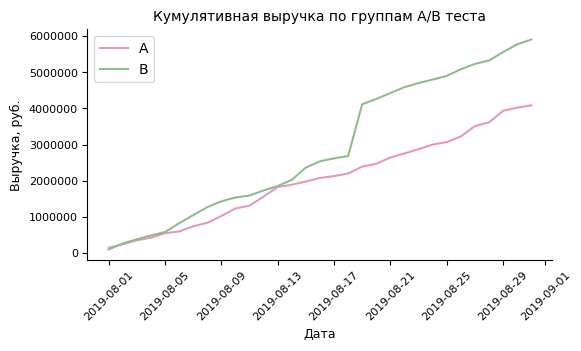

In [19]:
# строим график выручки по группам

plt.figure(figsize=(6,3))
plt.plot(cumulated_rev_A['date'], cumulated_rev_A['revenue'], label='A', color='palevioletred', alpha=.7)
plt.plot(cumulated_rev_B['date'], cumulated_rev_B['revenue'], label='B', color='darkseagreen')

plt.title('Кумулятивная выручка по группам А/В теста', fontsize=10)
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Выручка, руб.', fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.ticklabel_format(axis='y', style='plain')
plt.legend()
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** В группе А кумулятивная выручка растет практически равномерно на протяжении всего месяца тестирования, а в группе В наблюдается резкий рост около 19 августа. Данный скачок может быть связан с появлением дорогих заказов либо увеличением числа заказов, но в целом похож на аномалию, что мы исследуем далее. По неочищенным от выбросов данным группа В показывает кумулятивную выручку выше, чем группа А.

### Кумулятивный средний чек по группам

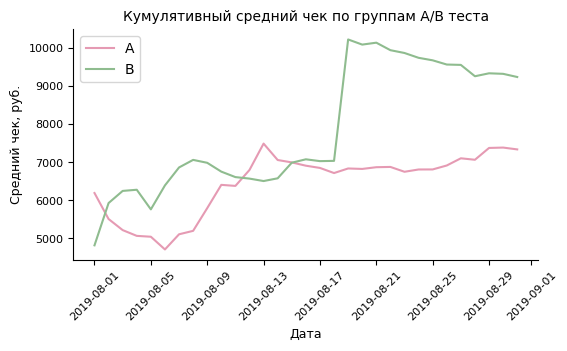

In [20]:
# строим график среднего чека по группам
# для этого делим кумулятивную выручку на кумулятивное число заказов

plt.figure(figsize=(6,3))
plt.plot(cumulated_rev_A['date'], cumulated_rev_A['revenue']/cumulated_rev_A['orders'], label='A',
         color='palevioletred', alpha=.7)
plt.plot(cumulated_rev_B['date'], cumulated_rev_B['revenue']/cumulated_rev_B['orders'], label='B',
         color='darkseagreen')

plt.title('Кумулятивный средний чек по группам А/В теста', fontsize=10)
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Средний чек, руб.', fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.legend()
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** Кумулятивный средний чек группы А колебался в начале теста и немного стабилизировался к концу, при этом в последних числах августа снова начал расти. Кумулятивный средний чек группы В колебался до 19 августа и затем резко вырос. Данная аномалия является причиной резкого роста выручки, который мы наблюдали выше. Какие-либо выводы о результатах теста по кумулятивному средрему чеку делать некорректно, нужно исследовать выбросы.

### Относительное изменение кумулятивного среднего чека

In [21]:
# объединим данные о кумулятивной выручке по обеим группам в одном датафрейме
# так, чтобы данные по разным группам находились в разных столбцах (для удобства расчета относит. изменения) 

cumulated_revenue = cumulated_rev_A.merge(cumulated_rev_B, on='date', how='left', suffixes=['A', 'B'])

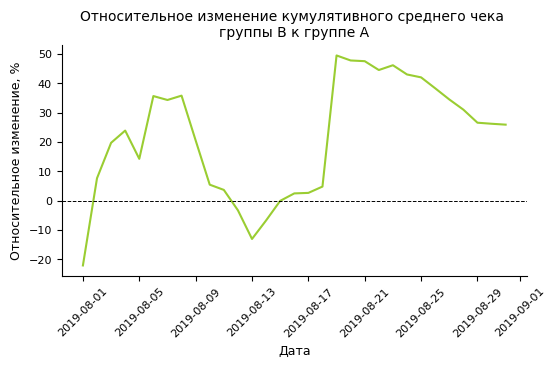

In [22]:
# cтроим график относительного изменения кумулятивного среднего чека

plt.figure(figsize=(6,3))
plt.plot(cumulated_revenue['date'],
         ((cumulated_revenue['revenueB']/cumulated_revenue['ordersB']) /
          (cumulated_revenue['revenueA']/cumulated_revenue['ordersA']) - 1) * 100,
         color='yellowgreen'
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--', linewidth=.7)

plt.title('Относительное изменение кумулятивного среднего чека \nгруппы B к группе A', fontsize=10)
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Относительное изменение, %', fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** Различие кумулятивного среднего чека между группами резко менялось несколько раз за период тестирования. Необходимо исследовать выбросы.

### Кумулятивная конверсия по группам

In [23]:
# считаем кумулятивную конверсию
cumulated_data['conversion'] = cumulated_data['buyers']/cumulated_data['visitors']

# выделим в отдельную переменную датафрейм с кумулятивными данными по группе А
cumulated_data_A = cumulated_data.query('group == "A"')

# выделим в отдельную переменную датафрейм с кумулятивными данными по группе B
cumulated_data_B = cumulated_data.query('group == "B"')

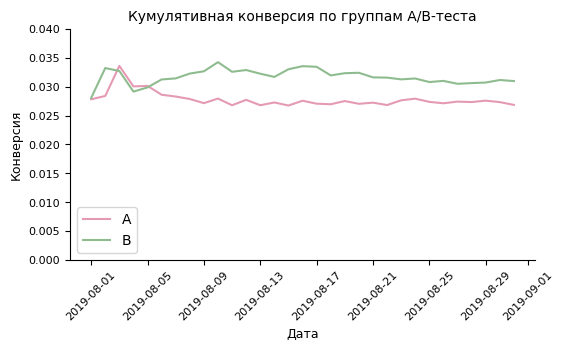

In [24]:
# строим график
plt.figure(figsize=(6,3))
plt.plot(cumulated_data_A['date'], cumulated_data_A['conversion'], label='A', color='palevioletred', alpha=.7)
plt.plot(cumulated_data_B['date'], cumulated_data_B['conversion'], label='B', color='darkseagreen')

plt.title('Кумулятивная конверсия по группам А/В-теста', fontsize=10)
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Конверсия', fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.ylim((0, 0.04))
plt.legend()
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** Конверсия обеих групп стабилизировалась к концу периода тестирования. Группа В лидирует по уровню конверсии на протяжении почти всего теста. Посмотрим далее, насколько постоянна разница конверсии группы В и группы А.

### Относительное изменение кумулятивной конверсии

In [25]:
# объединим данные о кумулятивной конверсии по обеим группам в одном датафрейме
# так, чтобы данные по разным группам находились в разных столбцах (для удобства расчета относит. изменения) 

cumulated_conversions = (cumulated_data_A[['date','conversion']]
                         .merge(cumulated_data_B[['date','conversion']],
                                on='date', how='left', suffixes=['A', 'B']))

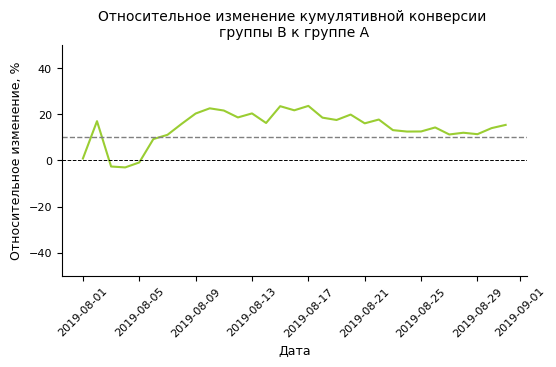

In [26]:
# строим график
plt.figure(figsize=(6,3))
plt.plot(cumulated_conversions['date'],
         (cumulated_conversions['conversionB'] / cumulated_conversions['conversionA'] - 1) * 100,
         color='yellowgreen')

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--', linewidth=.7)
# добавляем примерный итоговый уровень превышения конверсии группы В над конверсией группы А
plt.axhline(y=10, color='grey', linestyle='--', linewidth=1)

plt.title('Относительное изменение кумулятивной конверсии \nгруппы B к группе A', fontsize=10)
plt.xlabel('Дата', fontsize=9)
plt.ylabel('Относительное изменение, %', fontsize=9)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.ylim((-50, 50))
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** Конверсия группы В была лучше конверсии группы А практически с начала теста. На последней неделе теста превышение конверсии группы В над конверсией группы А стабилизировалось на уровне около 10%, а в конце теста продолжило расти.

### Количество заказов по пользователям

Чтобы выявить выбросы, проанализируем разброс числа заказов на одного пользователя.

In [27]:
# рассчитаем число заказов в разрезе пользователей

orders_by_users = (orders
                   .groupby('visitor_id', as_index=False)
                   .agg({'transaction_id':'nunique'})
                   .rename(columns=({'visitor_id':'user_id', 'transaction_id':'orders'}))
                  )

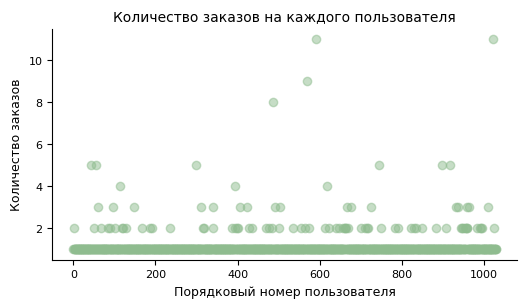

In [28]:
# построим график разброса количества заказов на пользователя

x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(6,3))
plt.scatter(x_values, orders_by_users['orders'], color='darkseagreen', alpha=.5)

plt.title('Количество заказов на каждого пользователя', fontsize=10)
plt.xlabel('Порядковый номер пользователя', fontsize=9)
plt.ylabel('Количество заказов', fontsize=9)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.gca().spines[['top','right']].set_visible(False)
plt.show()

**Наблюдения:** Пользователи в основном осуществляют до 2 заказов. Пользователей с числом заказов от 3 ед. совсем мало, и скорее всего, их можно считать выбросами. Посмотрим далее на выборочные перцентили, чтобы выяснить, какое число заказов одного пользователя действительно можно назвать аномальным.

---

In [29]:
# считаем 95-й и 99-й перцентили количества заказов на пользователя

orders_percentile = np.percentile(orders_by_users['orders'], [95, 99])
orders_percentile

array([2., 4.])

**Наблюдения:** Только 1% всех пользователей оформляли 4 и более заказа. Для 95% пользователей характерны 1-2 покупки. Таким образом, к аномальным пользователям будем относить тех, кто оформил более 2 заказов.

### Стоимость заказов

Чтобы выявить выбросы, проанализируем также разброс стоимости заказов.

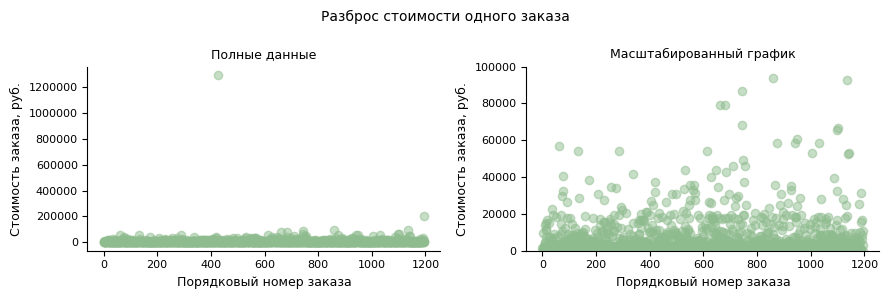

In [30]:
# построим точечный график стоимости заказов

x_values = pd.Series(range(0,len(orders['revenue'])))

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
axes[0].scatter(x_values, orders['revenue'], color='darkseagreen', alpha=.5)
axes[1].scatter(x_values, orders['revenue'], color='darkseagreen', alpha=.5)
            
plt.suptitle('Разброс стоимости одного заказа', fontsize=10)
axes[0].set_title('Полные данные', fontsize=9)
axes[1].set_title('Масштабированный график', fontsize=9)
axes[1].set_ylim(0, 100000)

axes[0].set_xlabel('Порядковый номер заказа', fontsize=9)
axes[0].set_ylabel('Стоимость заказа, руб.', fontsize=9)
axes[1].set_xlabel('Порядковый номер заказа', fontsize=9)
axes[1].set_ylabel('Стоимость заказа, руб.', fontsize=9)
axes[0].tick_params(axis='both', labelsize=8)
axes[1].tick_params(axis='both',labelsize=8)
axes[0].ticklabel_format(axis='y', style='plain')
axes[1].ticklabel_format(axis='y', style='plain')
axes[0].spines[['top','right']].set_visible(False)
axes[1].spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.show()

**Наблюдения:** На графике с полными данными сложно определить стандартную стоимость одного заказа из-за выбросов - слишком дорогих и нетипичных заказов стоимостью более 1,2 млн руб. и около 200 тыс. руб. Мы подготовили масштабированную версию данного графика, где отразили заказы стоимостью до 100 тыс. руб. (заказы на первом графике, кроме двух упомянутых выбросов, не превышают эту сумму).  
Основная часть заказов приходится на стоимость до 20 тыс. руб. Граница аномальной стоимости, скорее всего, будет лежать между 20 и 40 тыс. руб. Чтобы точнее определить её, посмотрим на перцентили.

---

In [31]:
# считаем 95-й и 99-й перцентили стоимости заказов

revenue_percentile = np.percentile(orders['revenue'], [95, 99])
revenue_percentile

array([28000. , 58233.2])

**Наблюдения:** Доля заказов, стоимость которых превышает 28 тыс. руб., составляет 5%; стоимость только 1% заказов превышает 58.2 тыс. руб. Аномальными заказами будем считать те, стоимость которых превысила 28 тыс. руб.

<a id='AB_test'></a>
## Оценка результатов A/B тестирования

### Различие в среднем числе заказов по «сырым» данным

В случае, когда в данных есть существенные выбросы, т.е. данные не распределены нормально, для оценки различий между выборками применяются непараметрические критерии, в частности критерий Манна-Уитни. Его и будем использовать далее для анализа.  

Для проверки критерием Манна-Уитни нужно собрать данные о числе заказов по всем пользователям каждой группы, т.е. учесть и тех пользователей, которые не оформляли заказы.

In [32]:
# рассчитаем число заказов для каждого покупателя групп А и В

orders_by_buyer_A = (orders.query('group == "A"')
                     .groupby('visitor_id', as_index=False)
                     .agg({'transaction_id':'nunique'})
                     .rename(columns=({'visitor_id':'user_id', 'transaction_id':'orders'}))
                    )

orders_by_buyer_B = (orders.query('group == "B"')
                     .groupby('visitor_id', as_index=False)
                     .agg({'transaction_id':'nunique'})
                     .rename(columns=({'visitor_id':'user_id', 'transaction_id':'orders'}))
                    )

# в переменных sample_A и sample_B сохраним число заказов каждого пользователя без его id
# у пользователей, которые ничего не заказывали, будут стоять нули

sample_A = pd.concat([orders_by_buyer_A['orders'],
                      pd.Series(0,
                                index=np.arange(visitors.query('group == "A"')['visitors'].sum() -
                                                len(orders_by_buyer_A)),
                                name='orders')
                     ], axis=0)

sample_B = pd.concat([orders_by_buyer_B['orders'],
                      pd.Series(0,
                                index=np.arange(visitors.query('group == "B"')['visitors'].sum() -
                                                len(orders_by_buyer_B)),
                                name='orders')
                     ], axis=0)

Проверяем нулевую гипотезу Н0: различия в среднем числе заказов между группами теста нет (распределение количества заказов одного пользователя группы А и группы В одинаково).  
Альтернативная гипотеза Н1: среднее число заказов между группами теста отличается (распределение количества заказов одного пользователя группы А и группы В различно).

Уровень значимости возьмем равный 5%.

In [33]:
# объявим функцию для оценки результатов теста

def test_results(group_1, group_2):
    alpha = .5
    p_value = st.mannwhitneyu(group_1, group_2)[1]
    print('p-value = {0:.5f}'.format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу') 

In [34]:
# оценим статистическую значимость различий в среднем количестве заказов по «сырым» данным

print('Относительное отличие среднего числа заказов группы В от среднего числа заказов группы А = {0:.2%}'
      .format(sample_B.mean() / sample_A.mean() - 1)
     )

test_results(sample_A, sample_B)

Относительное отличие среднего числа заказов группы В от среднего числа заказов группы А = 13.81%
p-value = 0.01679
Отвергаем нулевую гипотезу: между группами есть значимая разница


**Наблюдения:** P-value меньше уровня значимости 0.05. Следовательно, можно отвергнуть нулевую гипотезу о том, что различий в среднем числе заказов между группами нет. Среднее количество заказов пользователя группы В выше среднего количества заказов пользователя группы А на 13.81%, и разница статистически значима.

### Различие в среднем чеке по «сырым» данным

Проверяем нулевую гипотезу Н0: различия в среднем чеке между группами нет (распределение стоимости одного заказа группы А и группы В одинаково).  
Альтернативная гипотеза Н1: средний чек между группами отличается (распределение стоимости одного заказа группы А и группы В различно).

In [35]:
# оценим статистическую значимость различий в среднем чеке по «сырым» данным

print('Относительное отличие среднего чека группы В от среднего чека группы А = {0:.2%}'
      .format(orders.query('group == "B"')['revenue'].mean() /
              orders.query('group == "A"')['revenue'].mean() - 1)
     )

test_results(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])

Относительное отличие среднего чека группы В от среднего чека группы А = 25.87%
p-value = 0.72929
Не получилось отвергнуть нулевую гипотезу


**Наблюдения:** P-value значительно больше 0.05 - мы не можем отвергнуть нулевую гипотезу о том, что различий в среднем чеке между группами нет. Однако при этом средний чек группы В превышает средний чек группы А на 25.87%: причина в обнаруженных выбросах, и нужно повторить оценку различий, очистив данные от аномалий.

### Различие в среднем числе заказов по «очищенным» данным

Для исключения выбросов составим список id покупателей, которые попадают под установленные выше критерии аномалий: 1) пользователи, оформившие более 2 заказов, 2) пользователи, оформившие заказы стоимостью более 28 тыс. руб.

In [36]:
# выбираем пользователей, оформивших более 2 заказов
many_orders = pd.concat([orders_by_buyer_A.query('orders > @orders_percentile[0]')['user_id'],
                         orders_by_buyer_B.query('orders > @orders_percentile[0]')['user_id']
                        ], axis=0)

# выбираем пользователей, оформивших заказы стоимостью более 28 тыс. руб.
expensive_orders = orders.query('revenue > @revenue_percentile[0]')['visitor_id']

# объединяем в один реестр
abnormal_users = (pd.concat([many_orders, expensive_orders], axis=0)
                  .drop_duplicates()
                  .sort_values()
                 )

print('Число аномальных пользователей -', len(abnormal_users))

Число аномальных пользователей - 74


In [37]:
# очистим от аномальных пользователей выборки с количеством заказов на человека

sample_A_filtered = pd.concat([orders_by_buyer_A.query('~user_id.isin(@abnormal_users)')['orders'],
                               pd.Series(0,
                                         index=np.arange(visitors.query('group == "A"')['visitors'].sum() -
                                                         len(orders_by_buyer_A)),
                                         name='orders')
                              ], axis=0)

sample_B_filtered = pd.concat([orders_by_buyer_B.query('~user_id.isin(@abnormal_users)')['orders'],
                               pd.Series(0,
                                         index=np.arange(visitors.query('group == "B"')['visitors'].sum() -
                                                         len(orders_by_buyer_B)),
                                         name='orders')
                              ],axis=0)

Проверяем нулевую гипотезу Н0: различия в среднем числе заказов между группами нет (распределение количества заказов одного пользователя группы А и группы В одинаково).  
Альтернативная гипотеза Н1: среднее число заказов между группами отличается (распределение количества заказов одного пользователя группы А и группы В различно).

In [38]:
# оценим статистическую значимость различий в среднем количестве заказов по «очищенным» данным

print('Относительное отличие среднего числа заказов группы В от среднего числа заказов группы А = {0:.2%}'
      .format(sample_B_filtered.mean() / sample_A_filtered.mean() - 1)
     )

test_results(sample_A_filtered, sample_B_filtered)

Относительное отличие среднего числа заказов группы В от среднего числа заказов группы А = 17.27%
p-value = 0.01304
Отвергаем нулевую гипотезу: между группами есть значимая разница


**Наблюдения:** P-value немного снизился: с 0.017 до 0.013. Мы снова отвергаем нулевую гипотезу и принимаем альтернативную - различие в среднем количестве заказов между группами статистически значимо.  
Среднее число заказов одного пользователя в группе В выше, чем в группе А.

### Различие в среднем чеке по «очищенным» данным

Проверяем нулевую гипотезу Н0: различия в среднем чеке между группами нет (распределение стоимости одного заказа группы А и группы В одинаково).  
Альтернативная гипотеза Н1: средний чек между группами отличается (распределение стоимости одного заказа группы А и группы В различно).

In [39]:
# оценим статистическую значимость различий в среднем чеке по «очищенным» данным

print('Относительное отличие среднего чека группы В от среднего чека группы А = {0:.2%}'
      .format(orders.query('group == "B" and ~visitor_id.isin(@abnormal_users)')['revenue'].mean() /
              orders.query('group == "A" and ~visitor_id.isin(@abnormal_users)')['revenue'].mean() - 1)
     )

test_results(orders.query('group == "A" and ~visitor_id.isin(@abnormal_users)')['revenue'],
             orders.query('group == "B" and ~visitor_id.isin(@abnormal_users)')['revenue'])

Относительное отличие среднего чека группы В от среднего чека группы А = -1.96%
p-value = 0.73848
Не получилось отвергнуть нулевую гипотезу


**Наблюдения:** P-value немного вырос (был 0.729), и мы подтверждаем наш предыдущий вывод: различия в среднем чеке между группами не являются статистически значимыми. После исключения выбросов наблюдавшаяся разница минимизировалась, и по очищенным данным средний чек группы В немного ниже среднего чека группы А (почти на 2%). В целом нельзя сказать, что в какой-то из групп пользователи тратят больше или меньше.

<a id='summary'></a>
## Вывод

Мы проранжировали гипотезы по увеличению выручки в соответствии с фреймворками ICE и RICE и выбрали наиболее перспективную - *добавление формы подписки на новостную рассылку на все страницы сайта*.

Тест по выбранной гипотезе был запущен 1 августа 2019 г. и длился 1 месяц, после чего мы провели предварительный анализ результатов, чтобы принять решение об остановке или продолжении тестирования.

По итогам анализа мы выявили, что:  
- Кумулятивная выручка группы В выше группы А, однако при этом в группе В был аномально дорогой заказ стоимостью более 1,2 млн руб.;
- Конверсия группы В была лучше конверсии группы А практически с начала теста. На последней неделе теста превышение конверсии группы В над конверсией группы А стабилизировалось на уровне около 10%, а в конце теста продолжило расти;
- Пользователи группы В в среднем оформляли больше заказов, чем пользователи группы А, и это различие статистически значимо;
- Нельзя сказать, что в какой-то из групп средний чек больше или меньше: статистически значимого различия нет ни по "сырым" данным, ни по данным после фильтрации аномалий.

Рекомендуем остановить тест и признать его успешным: группа В лидирует по количеству заказов на пользователя и уровню конверсии.